In [4]:
import os
import sys
import math
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [5]:
SOURCE_DIR = '../datasets/fog-detection-dataset/fog_dataset'
CLASSES = []
for root, dirs, files in os.walk(SOURCE_DIR):
    for name in dirs:
        CLASSES.append(name)
CLASSES = sorted(CLASSES)

data = []
for c in CLASSES:
    for root, dirs, files in os.walk(os.path.join(SOURCE_DIR, c)):
        for name in files:
            data.append([os.path.join(root, name), c])
df = pd.DataFrame(data, columns=['image_path', 'class'])
df.head()

,image_path,class
0,../datasets/fog-detection-dataset/fog_dataset/...,fog images
1,../datasets/fog-detection-dataset/fog_dataset/...,fog images
2,../datasets/fog-detection-dataset/fog_dataset/...,fog images
3,../datasets/fog-detection-dataset/fog_dataset/...,fog images
4,../datasets/fog-detection-dataset/fog_dataset/...,fog images


In [3]:
df['class'].value_counts()

class
fog images        321
non-fog images    206
Name: count, dtype: int64

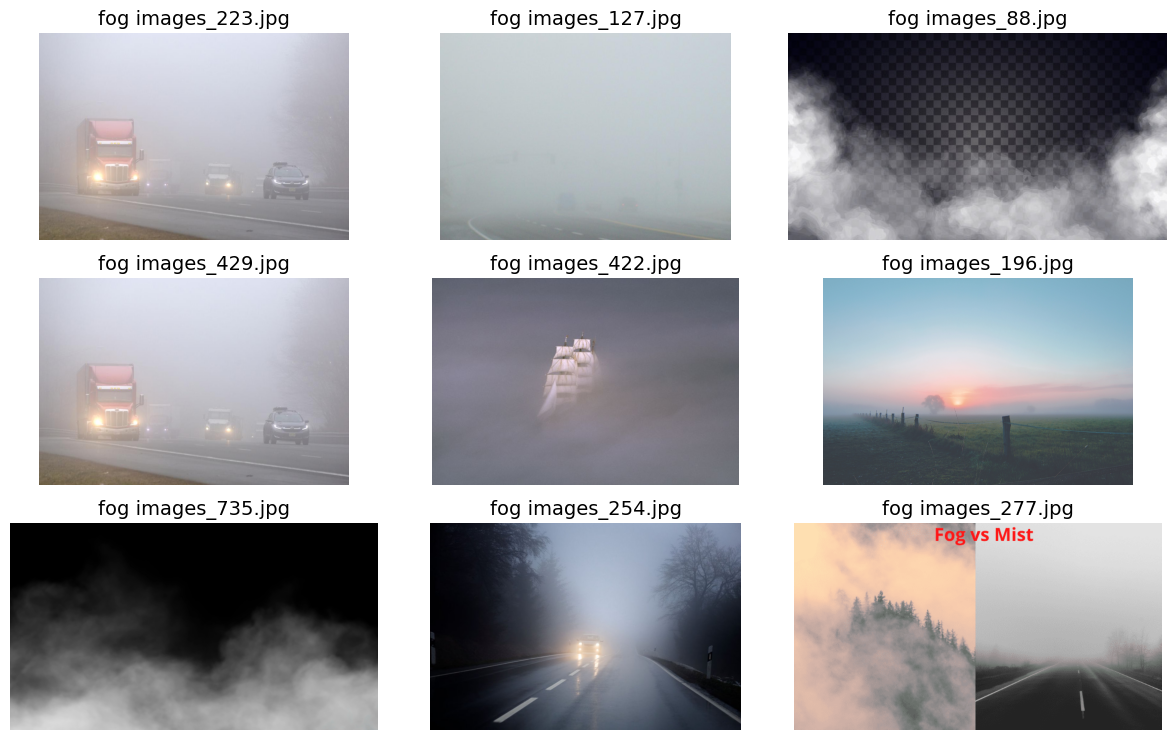

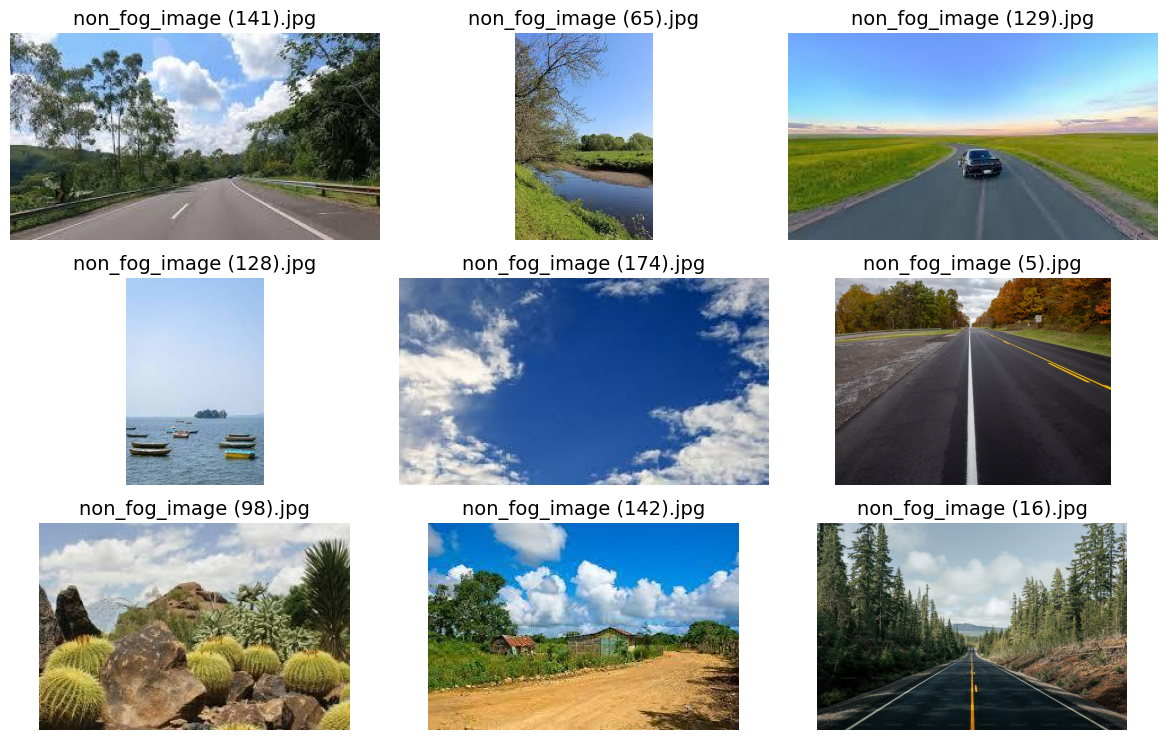

In [6]:
def plot_sample_images(df: pd.DataFrame, n: int, max_cols: int = 4, class_name: str = None):
    if class_name is not None:
        df = df[df['class'] == class_name]
    
    n = min(n, len(df))
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 2.5))
    axes = axes.flatten()

    # if class_name is not None:
    #     plt.suptitle(f"Class: {class_name}")

    sample = df.sample(n)
    for i, ax in enumerate(axes):
        img_path = sample['image_path'].iloc[i]
        img_class = sample['class'].iloc[i]
        img = Image.open(img_path)

        ax.imshow(img)
        if class_name is None:
            ax.set_title(f"Class: {img_class}", fontsize=14)
        else:
            file_name = img_path.rsplit("/", maxsplit=1)[1]
            ax.set_title(file_name, fontsize=14)
        ax.axis('off')
    for ax in axes[n:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

plot_sample_images(df, n=9, max_cols=3, class_name='fog images')
plot_sample_images(df, n=9, max_cols=3, class_name='non-fog images')

In [7]:
widths = []
heights = []

for img_path in df['image_path']:
    with Image.open(img_path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

df['width'] = widths
df['height'] = heights

[None]

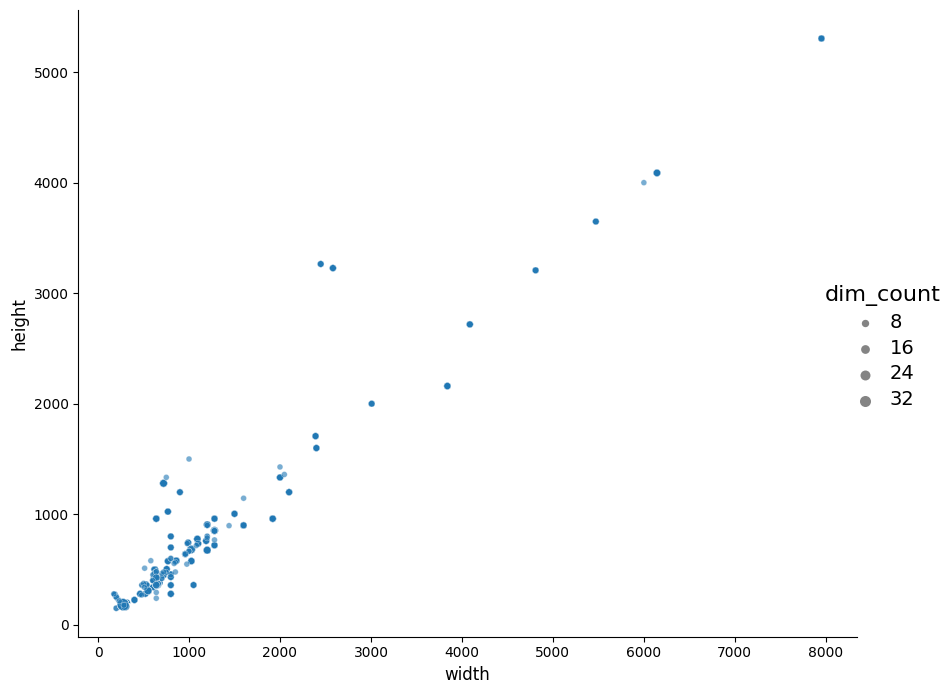

In [8]:
df_cp = df.copy()[['width', 'height']]
dimension_counts = df_cp.groupby(['width', 'height']).size().reset_index(name='dim_count')

df_cp = pd.merge(df_cp, dimension_counts, on=['width', 'height'], how='left')


r = sns.relplot(
    df_cp, x='width', y='height', size='dim_count',
    alpha=.6, height=7, aspect=1.25
)
r.set_xlabels("width", fontsize=12)
r.set_ylabels("height", fontsize=12)
r.tick_params(labelsize=10)
plt.setp(r.legend.get_texts(), fontsize=14)
plt.setp(r.legend.get_title(), fontsize=16)


In [6]:
def get_ext(p: str):
    return p.rsplit(".", maxsplit=1)[1]

df['ext'] = df['image_path'].apply(get_ext)
df['ext'].value_counts()

ext
jpg    527
Name: count, dtype: int64

100%|██████████| 321/321 [00:10<00:00, 31.40it/s]


Got 321 from 321


100%|██████████| 206/206 [00:00<00:00, 245.61it/s]


Got 206 from 206


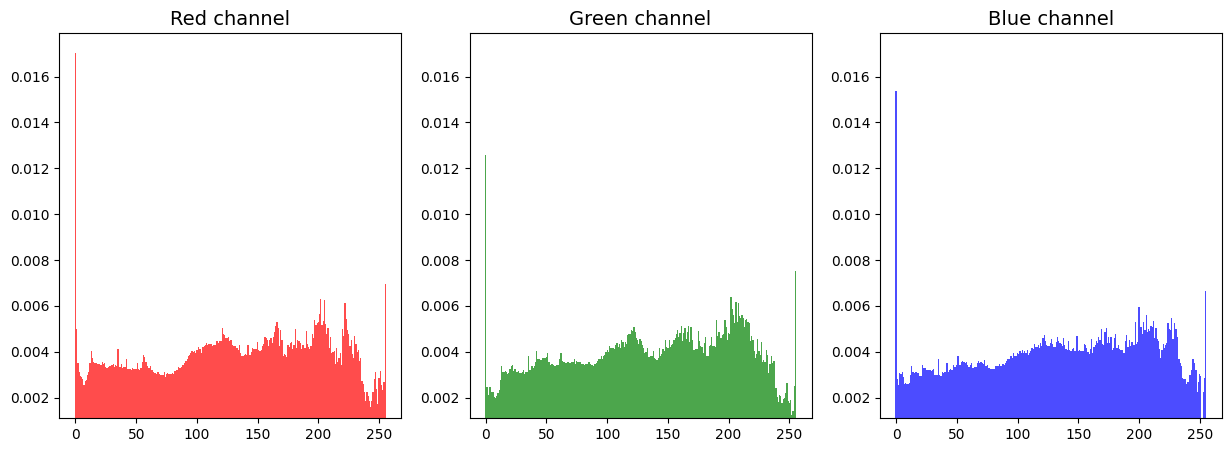

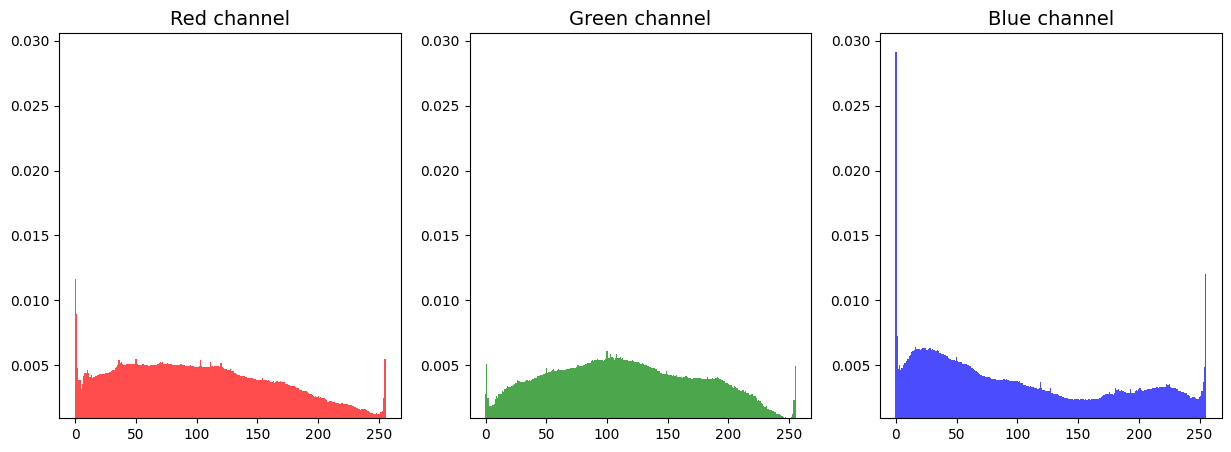

In [11]:
def plot_color_histogram(
        df: pd.DataFrame,
        bins: int = 256,
        title: str | None = None
):
    sum_r_norm_hist = np.zeros(bins, dtype=np.float64)
    sum_g_norm_hist = np.zeros(bins, dtype=np.float64)
    sum_b_norm_hist = np.zeros(bins, dtype=np.float64)

    n_images = 0
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = row['image_path']
        try:
            img = cv2.imread(image_path)
            if img is None:
                continue
            n_images += 1
            num_pixels = img.shape[0] * img.shape[1]
            hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
            sum_b_norm_hist += hist.squeeze() / num_pixels
            hist = cv2.calcHist([img], [1], None, [bins], [0, 256])
            sum_g_norm_hist += hist.squeeze() / num_pixels
            hist = cv2.calcHist([img], [2], None, [bins], [0, 256])
            sum_r_norm_hist += hist.squeeze() / num_pixels
        except:
            raise
    print(f"Got {n_images} from {len(df)}")
    sum_b_norm_hist /= n_images
    sum_g_norm_hist /= n_images
    sum_r_norm_hist /= n_images

    min_y = min(sum_b_norm_hist.min(), sum_g_norm_hist.min(), sum_r_norm_hist.min())
    max_y = max(sum_b_norm_hist.max(), sum_g_norm_hist.max(), sum_r_norm_hist.max()) * 1.05

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax3.bar(
        np.arange(0, 256),
        sum_b_norm_hist,
        width=1,
        alpha=.7,
        color='blue'
    )
    ax3.set_title('Blue channel', fontsize=14)
    ax2.bar(
        np.arange(0, 256),
        sum_g_norm_hist,
        width=1,
        alpha=.7,
        color='green'
    )
    ax2.set_title('Green channel', fontsize=14)
    ax1.bar(
        np.arange(0, 256),
        sum_r_norm_hist,
        width=1,
        alpha=.7,
        color='red'
    )
    ax1.set_title('Red channel', fontsize=14)
    ax3.set_ylim(min_y, max_y)
    ax2.set_ylim(min_y, max_y)
    ax1.set_ylim(min_y, max_y)
    if title is not None:
        fig.suptitle(title, fontsize=16)


plot_color_histogram(df[df['class'] == 'fog images'])
plot_color_histogram(df[df['class'] == 'non-fog images'])